![Logo de AA1](logo_AA1_texto_small.png) 
# Sesión 26 - Reducción de Dimensionalidad: Feature Extraction

Ya habíamos comentado en sesión anterior que la **Reducción de la Dimensionalidad** consiste en reducir el número de atributos obteniendo o creando un subconjunto de atributos o características que resuman la información relevante. 

Vimos que la Reducción de la Dimensionalidad puede lograrse por dos vías:
1. **Feature Selection** (Selección de Características), donde nos quedaremos con los atributos o características más relevantes del conjunto original.
2. **Feature Extraction** (Extracción de Características), donde crearemos nuevos atributos mediante la combinación de los atributos originales.

En esta sesión nos centraremos en la *Extracción de Características*.

Para ello vamos a utilizar un conjunto de datos que también trata de identificar dígitos a partir a partir de imágenes, pero en este caso, en lugar de partir de un conjunto de atributos reducido, trabajaremos con los atributos originales, los pixeles. Las imágenes son de tamaño $28 \times 28$, así que cada imagen tendrá un total de 784 pixeles y cada uno de ellos tendrá un valor entre 0 y 255 que indicará la intensidad de gris.

Se trata de un problema de clasificación donde hay que generar un modelo capaz de predecir el dígito al que corresponde la imagen. Hay 10 clases posibles que se corresponden con los 10 dígitos que hay entre el 0 y el 9.

En este caso, el conjunto de datos ya viene separado en entrenamiento y test (*mnist_train.pkl* y *mnist_test.pkl*) conteniendo cada uno de los ficheros un `DataFrame` con los datos necesarios. Cada fila del dataframe contiene 785 datos, que se corresponden con los 784 pixeles de una imagen y la clase (dígito) correspondiente a la imagen, que se sitúa en la última columna. Estos ficheros están codificados en formato `pickle`, que es un formato muy utilizado para *serializar* objetos, es decir codificar un objeto en un formato que nos permita transportarlo: https://es.wikipedia.org/wiki/Serialización 

Desde la librería `Pandas` es muy sencillo trabajar con el formato `pickle` puesto que disponemos de las funciones `to_pickle()` y `read_pickle()`:

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_pickle.html?highlight=to_pickle#pandas.DataFrame.to_pickle

https://pandas.pydata.org/docs/reference/api/pandas.read_pickle.html

In [1]:
import time
from random import randint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier

print('\n##########################################')
print('### cargar el conjunto de entrenamiento')
print('##########################################')

# leemos el conjunto de entrenamiento desde un fichero pkl
df_train = pd.read_pickle('mnist_train.pkl')
filas, columnas = df_train.shape

# la clase está en la última columna 
# separamos los atributos y los almacenamos en X
X_train = df_train.iloc[:,0:(columnas-1)]

# separamos la clase y la almacenamos en Y
y_train = df_train.iloc[:,(columnas-1)]

print('Número de ejemplos: ', X_train.shape[0])
print('Número de atributos:', X_train.shape[1])

print('\n##########################################')
print('### cargar el conjunto de test')
print('##########################################')

# leemos el conjunto de test desde un fichero pkl
df_test = pd.read_pickle('mnist_test.pkl')
filas, columnas = df_test.shape

# la clase está en la última columna 
# separamos los atributos y los almacenamos en X
X_test = df_test.iloc[:,0:(columnas-1)]

# separamos la clase y la almacenamos en Y
y_test = df_test.iloc[:,(columnas-1)]

print('Número de ejemplos: ', X_test.shape[0])
print('Número de atributos:', X_test.shape[1])


##########################################
### cargar el conjunto de entrenamiento
##########################################
Número de ejemplos:  60000
Número de atributos: 784

##########################################
### cargar el conjunto de test
##########################################
Número de ejemplos:  10000
Número de atributos: 784


Como veis, este conjunto de datos tiene muchos ejemplos y muchos atributos, así que los tiempos de entrenamiento pueden empezar a ser ya un poco más largos. Por ejemplo, el k-vecinos ya empezaría a tener dificultades puesto que para clasificar un solo ejemplo necesitaría calcular su distancia respecto a los 60000 ejemplos de conjunto de entrenamiento.

Veamos el rendimiento de un árbol de clasificación:

In [2]:
# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))

Accuracy árbol = 0.8773
Tiempo: 23.38 segundos


Podríamos obtener un rendimiento bastante más alto utilizando Random Forest, pero el tiempo de ejecición también sería superior. Para lo que queremos ver en esta sesión práctica continuaremos utilizando `DecisionTreeClassifier`.

Aunque los ejemplos ya nos vienen dados en forma de vector, comentamos al principio de la práctica que se correspondían con imágenes. Vamos a visualizar algunas de esas imágenes convirtiendo esos vectores en matrices de $28 \times 28$ y mostrándolos como imágenes:


##########################################
### visualizar ejemplos
##########################################


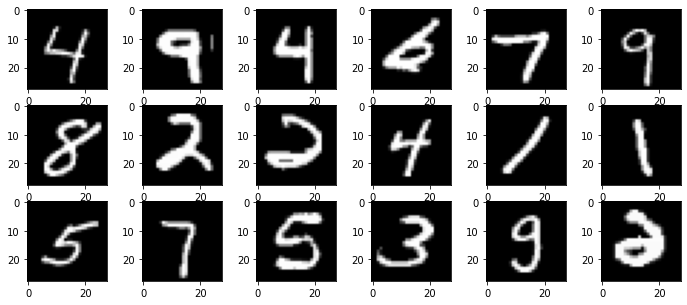

In [3]:
print('\n##########################################')
print('### visualizar ejemplos')
print('##########################################')

plt.figure(figsize=(12, 5))
for i in range(18):
    plt.subplot(3, 6, i+1)
    idx = randint(0, X_train.shape[0]) # seleccionamos una imagen al azar y la mostramos
    plt.imshow(X_train.values[idx].reshape((28,28)), cmap=plt.get_cmap('gray'))
plt.show()

Hemos hecho que las imágenes se vayan eligiendo de forma aleatoria, así que si vuelves a ejecutar el código anterior se mostrarán otras 18 imágenes diferentes.

## 26.1 Análisis de Componentes Principales

El Análisis de Componentes Principales o PCA es el método más polular de extracción de características.

PCA trata de encontrar un nuevo conjunto de ejes ortogonales en el que la varianza de los datos sea máxima en alguna dirección. Realiza el proceso de manera secuencial, es decir:
1. busca una combinación lineal de los atributos que maximiza la varianza en alguna dirección (esta sería la primera componente principal o PC1)
2. se busca la siguiente componente principal, que debe ser perpendicular a la anterior y debe maximizar la varianza en alguna de las direcciones posibles
3. se repite el paso 2

El Análisis de Componentes Principales **no utiliza la clase** en su análisis, se trata de un sistema no supervisado.

No vamos a entrar en detalles teóricos puesto que el Análisis de Componentes Principales se explica en detalle en la asignatura "Análisis de Datos" de segundo curso y segundo cuatrimestre.

Suele utilizarse con dos fines:
- obtener un conjunto de atributos más manejable
- visualizar los datos en un espacio de dimensiones reducido

### 26.1.1 Obtener un número de atributos manejable

El primero de los objetivos es reducir la dimensionalidad para facilitar posteriores procesos de aprendizaje.

Vamos a ver qué ocurre si a partir de los 784 atributos iniciales buscamos únicamente 20 componentes principales:

In [4]:
print('\n##########################################')
print('### PCA')
print('##########################################')

num_componentes = 20
pca = PCA(n_components=num_componentes)

# se toman tiempos de ejecución 
ini = time.time()
pca.fit(X_train)  # OJO, no necesita la clase para entrenar
fin = time.time()
print("Tiempo: %.2f segundos" % (fin-ini))

X_train_pca = pca.transform(X_train)
print(X_train_pca.shape)


##########################################
### PCA
##########################################
Tiempo: 2.84 segundos
(60000, 20)


Hemos obtenido las 20 componentes (en muy poco tiempo) y hemos proyectado `X_train` en el espacio de esas 20 componentes almacenando el resultado en `X_train_pca`. 

Fijaros en que al realizar la llamada a `fit()` no es necesario pasarle `y_train` ya que el Análisis de Componentes Principales no utiliza la clase en su análisis.

Vamos a ver cuál será el rendimiento de un árbol de decisión en este nuevo espacio:

In [5]:
print('\n##########################################')
print('### Rendimiento con PCA -', num_componentes, 'componentes')
print('##########################################')

X_test_pca = pca.transform(X_test)

# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train_pca, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test_pca)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))


##########################################
### Rendimiento con PCA - 20 componentes
##########################################
Accuracy árbol = 0.8461
Tiempo: 3.82 segundos


El rendimiento es un poco peor, pero vemos que el árbol a tardado muchísimo menos en entrenarse.

A veces, estas reducciones de tiempo son la diferencia entre que un sistema sea útil o no.

Si aumentásemos el número de componentes principales iríamos mejorando el rendimiento y empeorando en tiempo de ejecución.

Veamos lo que aporta cada componente principal:


##########################################
### Gráfica varianza -  20 componentes
##########################################


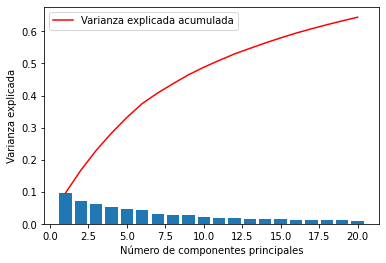

In [6]:
print('\n##########################################')
print('### Gráfica varianza - ', num_componentes, 'componentes')
print('##########################################')

fig, ax = plt.subplots()

# Gráfico para ver la varianza explicada por cada componente principal
ax.bar(range(1,len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_)

# Gráfico para ver la varianza explicada acumulada
ax.plot(range(1,len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), 
                c='red', label='Varianza explicada acumulada')
 
ax.legend(loc='upper left')
ax.set_xlabel('Número de componentes principales')
ax.set_ylabel('Varianza explicada')
plt.show()

Utilizando el atributo `explained_variance_ratio` podemos ver la varianza explicada por cada una de las componentes principales y la varianza explicada que acumulan todas ellas.

Utilizando 20 componentes vemos que podemos explicar algo más del 60% de la varianza en los datos y que la primera componente explica casi el 10%.

### 26.1.2 Visualizar los datos

Otro de los usos importantes del Análisis de Componentes Principales es la visualización de los datos.

Si trabajamos únicamente con las 2 primeras componentes podremos representar los datos en un gráfico:


##########################################
### PCA - 2 componentes
##########################################
Tiempo: 2.35 segundos

##########################################
### Visualizar los datos
##########################################


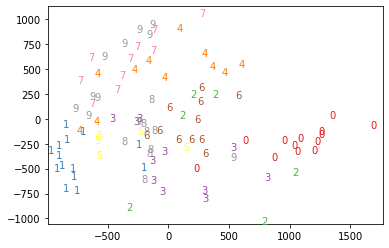


##########################################
### Rendimiento con PCA - 2 componentes
##########################################
Accuracy árbol = 0.3802
Tiempo: 0.37 segundos


In [7]:
print('\n##########################################')
print('### PCA - 2 componentes')
print('##########################################')

pca = PCA(n_components=2)

# se toman tiempos de ejecución 
ini = time.time()
pca.fit(X_train)  # OJO, no necesita la clase para entrenar
fin = time.time()
print("Tiempo: %.2f segundos" % (fin-ini))

X_train_pca = pca.transform(X_train)

print('\n##########################################')
print('### Visualizar los datos')
print('##########################################')

cuantos = 100
[max_cp1, max_cp2] = X_train_pca[:cuantos].max(axis=0)
[min_cp1, min_cp2] = X_train_pca[:cuantos].min(axis=0)

fig, ax = plt.subplots()
for i in range(cuantos): 
    ax.text(X_train_pca[i, 0], X_train_pca[i, 1], str(y_train[i]), color=plt.cm.Set1(y_train[i])) 
ax.set_xlim([min_cp1, max_cp1+100])
ax.set_ylim([min_cp2, max_cp2+100])
plt.show()

print('\n##########################################')
print('### Rendimiento con PCA - 2 componentes')
print('##########################################')

X_test_pca = pca.transform(X_test)

# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train_pca, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test_pca)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))

Se han mostrado solo 100 ejemplos para que se pueda visualizar con mayor claridad.

Podemos apreciar en la gráfica cómo estas dos componentes ya son capaces de diferenciar algunas de las clases.

Evidentemente, el resultado que se obtiene con un árbol de decisión utilizando estas dos variables es muy pobre, algo que se podría preveer ya que estas dos primeras componentes apenas explican el 18% de la varianza.

Sin embargo, veréis que esta es una técnica muy utilizada para visualizar los datos.

Podemos también utilizar las 3 primeras componentes:


##########################################
### PCA - 3 componentes
##########################################
Tiempo: 2.37 segundos

##########################################
### Visualizar los datos
##########################################


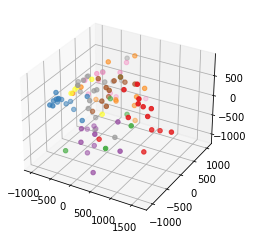


##########################################
### Rendimiento con PCA - 3 componentes
##########################################
Accuracy árbol = 0.4364
Tiempo: 0.54 segundos


In [8]:
print('\n##########################################')
print('### PCA - 3 componentes')
print('##########################################')

pca = PCA(n_components=3)

# se toman tiempos de ejecución 
ini = time.time()
pca.fit(X_train)  # OJO, no necesita la clase para entrenar
fin = time.time()
print("Tiempo: %.2f segundos" % (fin-ini))

X_train_pca = pca.transform(X_train)

print('\n##########################################')
print('### Visualizar los datos')
print('##########################################')

cuantos = 100
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_pca[:cuantos,0], X_train_pca[:cuantos,1], X_train_pca[:cuantos,2], c=y_train[:cuantos], cmap=plt.cm.Set1)
plt.show()

print('\n##########################################')
print('### Rendimiento con PCA - 3 componentes')
print('##########################################')

X_test_pca = pca.transform(X_test)

# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train_pca, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test_pca)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))

Los resultados mejoran un poco y todavía se pueden visualizar los datos. Si implementáis esto mismo en un script o programa podréis rotar el gráfico para verlo desde el ángulo que queráis y veréis cómo las clases están algo más diferenciadas.

## 26.2 Análisis Discriminante Lineal

El Análisis Discriminante Lineal (LDA) también busca combinaciones lineales de los atributos para obtener nuevos atributos con mayor riqueza explicativa. 

LDA parte con cierta ventaja puesto que **se apoya en la clase para el cálculo de los nuevos atributos**. Su implementación en `Scikit-learn` tiene el nombre de `LinearDiscriminantAnalysis` y tiene un funcionamiento muy similar al de `PCA`. 

En LDA el número máximo de componentes que se puede calcular es igual al número de clases del problema menos 1.

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

No vamos a entrar en detalles teóricos puesto que, al igual que ocurre con el Análisis de Componente Principales, el LDA se explica en detalle en la asignatura "Análisis de Datos" de segundo curso y segundo cuatrimestre.

Fijáos que en el `fit()` debemos indicar la clase:



##########################################
### LinearDiscriminantAnalysis - 2 componentes
##########################################
Tiempo: 12.65 segundos

##########################################
### Visualizar los datos
##########################################


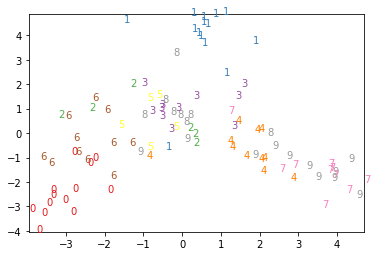


##########################################
### Rendimiento con LinearDiscriminantAnalysis - 2 componentes
##########################################
Accuracy árbol = 0.4745
Tiempo: 0.38 segundos


In [9]:
print('\n##########################################')
print('### LinearDiscriminantAnalysis - 2 componentes')
print('##########################################')

lda = LinearDiscriminantAnalysis(n_components=2)

# se toman tiempos de ejecución 
ini = time.time()
lda.fit(X_train, y_train)  # OJO, necesita la clase
fin = time.time()
print("Tiempo: %.2f segundos" % (fin-ini))

X_train_lda = lda.transform(X_train)

print('\n##########################################')
print('### Visualizar los datos')
print('##########################################')

cuantos = 100
[max_cp1, max_cp2] = X_train_lda[:cuantos].max(axis=0)
[min_cp1, min_cp2] = X_train_lda[:cuantos].min(axis=0)

fig, ax = plt.subplots()
for i in range(cuantos): 
    ax.text(X_train_lda[i, 0], X_train_lda[i, 1], str(y_train[i]), color=plt.cm.Set1(y_train[i])) 
ax.set_xlim([min_cp1, max_cp1])
ax.set_ylim([min_cp2, max_cp2])
plt.show()

print('\n##########################################')
print('### Rendimiento con LinearDiscriminantAnalysis - 2 componentes')
print('##########################################')

X_test_lda = lda.transform(X_test)

# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train_lda, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test_lda)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))

El código es equivalente al visto con `PCA`.

Vemos que ha tardado un poco más en calcular las componentes, sin embargo, podemos apreciar en el gráfico que ha separado un poco mejor las clases y eso facilita el trabajo del árbol de decisión, que tarda menos en entrenarse y obtiene un resultado mejor.

Podemos ver qué sucede utilizando 3 componentes:


##########################################
### LinearDiscriminantAnalysis - 3 componentes
##########################################
Tiempo: 12.30 segundos

##########################################
### Visualizar los datos
##########################################


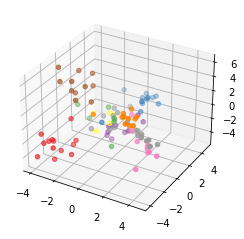


##########################################
### Rendimiento con LinearDiscriminantAnalysis - 3 componentes
##########################################
Accuracy árbol = 0.6619
Tiempo: 0.49 segundos


In [10]:
print('\n##########################################')
print('### LinearDiscriminantAnalysis - 3 componentes')
print('##########################################')

lda = LinearDiscriminantAnalysis(n_components=3)

# se toman tiempos de ejecución 
ini = time.time()
lda.fit(X_train, y_train)  # OJO, necesita la clase
fin = time.time()
print("Tiempo: %.2f segundos" % (fin-ini))

X_train_lda = lda.transform(X_train)

print('\n##########################################')
print('### Visualizar los datos')
print('##########################################')

cuantos = 100
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_lda[:cuantos,0], X_train_lda[:cuantos,1], X_train_lda[:cuantos,2], c=y_train[:cuantos], cmap=plt.cm.Set1)
plt.show()

print('\n##########################################')
print('### Rendimiento con LinearDiscriminantAnalysis - 3 componentes')
print('##########################################')

X_test_lda = lda.transform(X_test)

# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train_lda, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test_lda)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))

Como vemos mejora el rendimiento considerablemente y en la figura podemos apreciar las clases algo más separadas.

Vamos a probar con distinto número de componentes (recuerda que con 10 clases LDA puede calcular como mucho 9 componentes):


##########################################
### LinearDiscriminantAnalysis
##########################################
Tiempo: 12.27 segundos

##########################################
### Gráfica varianza -  9 componentes
##########################################


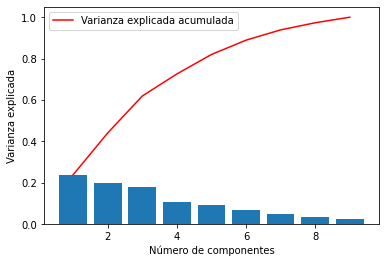


##########################################
### Rendimiento con LinearDiscriminantAnalysis -  9 componentes
##########################################
Accuracy árbol = 0.8552
Tiempo: 1.69 segundos


In [11]:
print('\n##########################################')
print('### LinearDiscriminantAnalysis')
print('##########################################')

num_componentes = 9
lda = LinearDiscriminantAnalysis(n_components=num_componentes)

# se toman tiempos de ejecución 
ini = time.time()
lda.fit(X_train, y_train)  # OJO, necesita la clase
fin = time.time()
print("Tiempo: %.2f segundos" % (fin-ini))

X_train_lda = lda.transform(X_train)

print('\n##########################################')
print('### Gráfica varianza - ', num_componentes, 'componentes')
print('##########################################')

fig, ax = plt.subplots()

# Gráfico para ver la varianza explicada por cada componente principal
ax.bar(range(1,len(lda.explained_variance_ratio_)+1), lda.explained_variance_ratio_)

# Gráfico para ver la varianza explicada acumulada
ax.plot(range(1,len(lda.explained_variance_ratio_)+1), np.cumsum(lda.explained_variance_ratio_), 
                c='red', label='Varianza explicada acumulada')
 
ax.legend(loc='upper left')
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza explicada')
plt.show()


print('\n##########################################')
print('### Rendimiento con LinearDiscriminantAnalysis - ', num_componentes, 'componentes')
print('##########################################')

X_test_lda = lda.transform(X_test)

# creamos un árbol, entrenamos y evaluamos
sys_tree = DecisionTreeClassifier(random_state=1234)

# se toman tiempos de ejecución 
ini = time.time()
sys_tree.fit(X_train_lda, y_train)
fin = time.time()

y_pred = sys_tree.predict(X_test_lda)
acc_tree =  metrics.accuracy_score(y_test, y_pred)
print("Accuracy árbol = %.4f" % acc_tree)
print("Tiempo: %.2f segundos" % (fin-ini))

Vemos que las 3 primeras componentes ya explican en torno al 60% de la varianza. 

Utilizando el máximo número de componentes se explica el 100% de la varianza. El árbol que se entrena con estas 9 componentes es rápido en su aprendizaje y además tiene una accuracy cercana a la que se obtiene utilizando todos los atributos originales.

## Ejercicios

1. Carga el conjunto de datos  **gastroenterology.data** (OJO, los ejemplos vienen colocados en columnas, no en filas, y el número de ejemplos y atributos no coincide con lo indicado en en names)
2. Sepáralo en 80% para entrenar y 20% para test.
3. Prueba los algoritmos `PCA` y `LinearDiscriminantAnalysis` 

Estos ejercicios no es necesario entregarlos.